* 다루기 힘든 비선형 문제를 선형 분류기에 적합한 새로운 저차원 부분 공간으로 변환하여 진행

### 커널 함수와 커널 트릭
* 커널SVM에서 나왔듯이 매핑함수를 통해 데이터를 고차원 공간으로 변환하고 다시 PCA를 사용하여 선형 분류기로 구분될 수 있는 저차원 공간으로 데이터를 투영한다. 단점으로는 계산 비용이 매우 비싸기 때문에 커널 트릭이 등장한다.
* 널리 사용되는 커널 :
    * 다항 커널
    * 하이퍼볼릭 탄젠트(시그모이드)
    * 방사 기저 함수
   
* 커널 PCA를 구현하기 위한 세 단계
    * 커널(유사도) 행렬 K를 계산한다.
    * 다음 식을 사용하여 커널 행렬 K를 중앙에 맞춘다 여기서 $1_n$은 모든 값이 $\frac{1}{n}$인 행렬이다
    $$ K' = K - 1_nK - K1_n + 1_nK1_n $$
    * 고유값 크기대로 내림차순으로 정렬하여 중앙에 맞춘 커널 행렬에서 최상위 k개의 고유벡터를 고른다. 표준PCA와 다르게 고유 벡터는 주성분 축이 아니며, 이미 이 축에 투영된 샘플이다.
    

In [1]:
# 두번째 단계 중앙 맞추기
from skleran.preprocessing import KernelCenterer

K_centered = KernelCenterer().fit_transform(K)

### 파이썬으로 커널 PCA 구현

In [19]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    
    # Mxn 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산
    sq_dists = pdist(X, 'sqeuclidean')
    
    # 샘플 간의 거리를 정방 대칭 행렬로 변환합니다
    mat_sq_dists = squareform(sq_dists)
    
    # 커널 행렬을 계산합니다
    K = exp(-gamma * mat_sq_dists)
    
    # 커널 행렬을 중앙에 맞춘다
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 중앙에 맞춰진 커널 행렬의 고유값과 고유 벡터를 구한다
    # scipy.linalg.eigh 함수는 오름차순으로 반환한다
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:,::-1]
    
    # 최상위 k개의 고유 벡터를 선택
    X_pc = np.column_stack([eigvecs[:,i] for i in range(n_components)])
    
    return X_pc

* 차원축소에 RBF 커널 PCA를 사용하는 한 가지 단점은 사전에 $ \gamma$ 매개변수를 지정해야 한다는 것이다. 적절한 값을 찾으려면 실험을 해야하며 그리드 서치 같은 매개변수 튜닝을 위한 알고리즘을 사용하는 것이 최선이다

* 예제 1: 반달 모양 구분하기

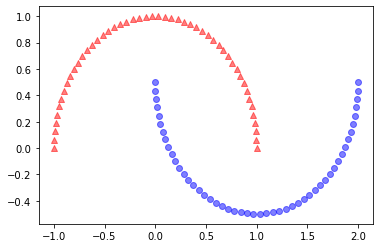

[[ 8.71318704e-01  4.90717552e-01]
 [ 7.15472413e-01 -4.58667853e-01]
 [ 1.46253829e+00 -3.86599306e-01]
 [-2.22520934e-01  9.74927912e-01]
 [ 3.27699110e-01 -2.40277997e-01]
 [ 1.00000000e+00  0.00000000e+00]
 [ 9.49055747e-01  3.15108218e-01]
 [ 0.00000000e+00  5.00000000e-01]
 [ 1.40478334e+00 -4.14412623e-01]
 [ 9.67294863e-01  2.53654584e-01]
 [ 9.60230259e-02  9.95379113e-01]
 [ 4.27883340e-01 -3.20172255e-01]
 [ 1.09602303e+00 -4.95379113e-01]
 [ 1.98586378e-01 -9.81105305e-02]
 [ 3.20515776e-02  9.99486216e-01]
 [-9.00968868e-01  4.33883739e-01]
 [ 1.15959990e+00 -4.87181783e-01]
 [-7.61445958e-01  6.48228395e-01]
 [ 7.30832427e-02  1.24732995e-01]
 [ 1.03205158e+00 -4.99486216e-01]
 [-6.23489802e-01  7.81831482e-01]
 [ 1.76144596e+00 -1.48228395e-01]
 [ 3.45365054e-01  9.38468422e-01]
 [-2.84527587e-01  9.58667853e-01]
 [-4.04783343e-01  9.14412623e-01]
 [ 1.87131870e+00  9.28244800e-03]
 [ 1.62348980e+00 -2.81831482e-01]
 [ 8.38088105e-01  5.45534901e-01]
 [ 1.84408430e-02  3

In [27]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
X, y =make_moons(n_samples = 100, random_state = 123)
plt.scatter(X[y==0,0],X[y==0,1], color='red', marker='^',alpha=0.5)
plt.scatter(X[y==1,0],X[y==1,1], color='blue', marker='o',alpha=0.5)
plt.show()
print(X, y)

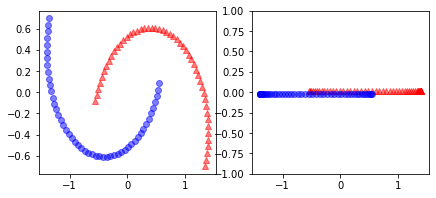

In [21]:
# 선형적으로 구분되지 않는 데이터를 기본 PCA의 주성분에 데이터셋을 투영
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components = 2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows =1, ncols = 2, figsize=(7,3))
ax[0].scatter(X_spca[y==0,0], X_spca[y==0,1],color='red',marker='^',alpha=0.5)
ax[0].scatter(X_spca[y==1,0], X_spca[y==1,1],color='blue',marker='o',alpha=0.5)
ax[1].scatter(X_spca[y==0,0], np.zeros((50,1))+0.02,color='red',marker='^',alpha=0.5)
ax[1].scatter(X_spca[y==1,0], np.zeros((50,1))-0.02,color='blue',marker='o',alpha=0.5)
ax[1].set_ylim([-1,1])
plt.show()

<ipython-input-19-6b3cf822be1f>:15: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)


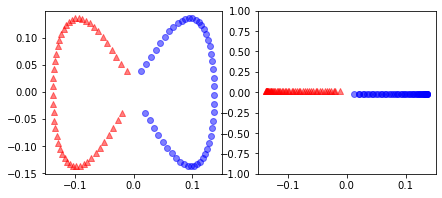

In [23]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows =1, ncols = 2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0,0], X_kpca[y==0,1],color='red',marker='^',alpha=0.5)
ax[0].scatter(X_kpca[y==1,0], X_kpca[y==1,1],color='blue',marker='o',alpha=0.5)
ax[1].scatter(X_kpca[y==0,0], np.zeros((50,1))+0.02,color='red',marker='^',alpha=0.5)
ax[1].scatter(X_kpca[y==1,0], np.zeros((50,1))-0.02,color='blue',marker='o',alpha=0.5)
ax[1].set_ylim([-1,1])
plt.show()
# 이제 이 데이터는 선형적으로 구분이 잘되므로 선형 분류기를 위한 훈련 데이터로 적합하다

* 예제 2 : 동심원 분리하기

In [29]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples = 1000, random_state = 123, noise = 0.1, factor = 0.2)
print(X , '\n',y)

[[-0.08769568  1.08597835]
 [-0.83755821  0.54731034]
 [ 0.79684284  0.41149548]
 ...
 [ 0.28197613 -0.99058106]
 [-0.13945495 -0.99992483]
 [-0.06902609  0.09488232]] 
 [0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0
 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0
 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0
 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1
 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1
 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1
 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1
 1 1 

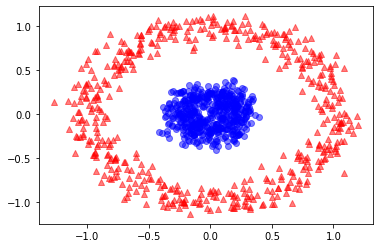

In [30]:
plt.scatter(X[y==0,0],X[y==0,1], color='red', marker='^',alpha=0.5)
plt.scatter(X[y==1,0],X[y==1,1], color='blue', marker='o',alpha=0.5)
plt.show()

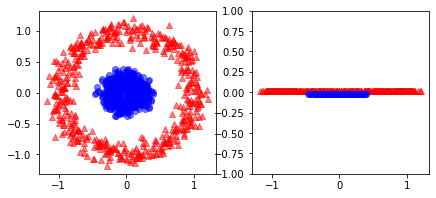

In [32]:
scikit_pca = PCA(n_components = 2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows =1, ncols = 2, figsize=(7,3))
ax[0].scatter(X_spca[y==0,0], X_spca[y==0,1],color='red',marker='^',alpha=0.5)
ax[0].scatter(X_spca[y==1,0], X_spca[y==1,1],color='blue',marker='o',alpha=0.5)
ax[1].scatter(X_spca[y==0,0], np.zeros((500,1))+0.02,color='red',marker='^',alpha=0.5)
ax[1].scatter(X_spca[y==1,0], np.zeros((500,1))-0.02,color='blue',marker='o',alpha=0.5)
ax[1].set_ylim([-1,1])
plt.show()

<ipython-input-19-6b3cf822be1f>:15: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)


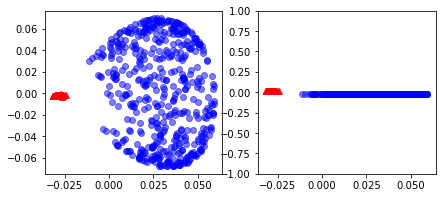

In [33]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows =1, ncols = 2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0,0], X_kpca[y==0,1],color='red',marker='^',alpha=0.5)
ax[0].scatter(X_kpca[y==1,0], X_kpca[y==1,1],color='blue',marker='o',alpha=0.5)
ax[1].scatter(X_kpca[y==0,0], np.zeros((500,1))+0.02,color='red',marker='^',alpha=0.5)
ax[1].scatter(X_kpca[y==1,0], np.zeros((500,1))-0.02,color='blue',marker='o',alpha=0.5)
ax[1].set_ylim([-1,1])
plt.show()

### 새로운 데이터 포인트 투영

### 사이킷런의 커널 PCA

In [34]:
from sklearn.decomposition import KernelPCA

X,y = make_moons(n_samples = 100, random_state = 123)
scikit_kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 15)
X_skernpca = scikit_kpca.fit_transform(X)

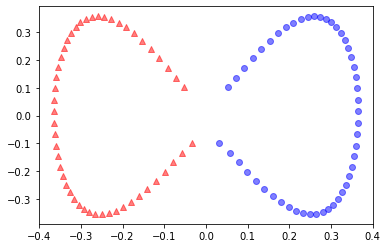

In [35]:
plt.scatter(X_skernpca[y==0,0],X_skernpca[y==0,1], color='red', marker='^',alpha=0.5)
plt.scatter(X_skernpca[y==1,0],X_skernpca[y==1,1], color='blue', marker='o',alpha=0.5)
plt.show()